## Import library

In [1]:
import sys
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib'
)

import data_load
import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import matplotlib.pyplot as plt

from tqdm import tqdm

import dowhy.datasets
import dowhy
from dowhy import CausalModel


from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV


/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

In [12]:
df = pd.read_csv("/home/dtd/Documents/interpretable_machine_learning/Source Code/data/bank/bank-full.csv", sep = ";")

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df['treatment'] = np.where(df['pdays'] == -1, 1, 0)
df['y'] = np.where(df['y'] == 'no', 0, 1)

In [5]:
le = LabelEncoder()

le.fit(df['education'])
df['education'] = le.transform(df['education'])

le.fit(df['marital'])
df['marital'] = le.transform(df['marital'])

le.fit(df['housing'])
df['housing'] = le.transform(df['housing'])

le.fit(df['loan'])
df['loan'] = le.transform(df['loan'])

le.fit(df['job'])
df['job'] = le.transform(df['job'])

le.fit(df['contact'])
df['contact'] = le.transform(df['contact'])

le.fit(df['poutcome'])
df['poutcome'] = le.transform(df['poutcome'])

In [6]:
outcome = "y"
treatment = "treatment"

col = list(df.columns)
col.remove("pdays")
col.remove("default")
col.remove("month")
col.remove("day")

print(col)

cov = col[:]
cov.remove(treatment)
cov.remove(outcome)
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'previous', 'poutcome', 'y', 'treatment']
['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'previous', 'poutcome']
['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'previous', 'poutcome', 'treatment']


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,treatment
0,58,4,1,2,no,2143,1,0,2,5,may,261,1,-1,0,3,0,1
1,44,9,2,1,no,29,1,0,2,5,may,151,1,-1,0,3,0,1
2,33,2,1,1,no,2,1,1,2,5,may,76,1,-1,0,3,0,1
3,47,1,1,3,no,1506,1,0,2,5,may,92,1,-1,0,3,0,1
4,33,11,2,3,no,1,0,0,2,5,may,198,1,-1,0,3,0,1


In [8]:
## Fit treatment
model_t = LogisticRegression()
model_t.fit(df[cov], df[treatment])

df['p1'] = model_t.predict_proba(df[cov])[:,1]
df['p0'] = 1 - df['p1']


df["prediction"] = np.where(df["p1"] >= 0.5, 1, 0)
acc = accuracy_score(df["prediction"], df["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(df[features], df[outcome])
    


/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score of train data 0.9999778814890181


GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [9]:
effects = []
delta_seq = np.linspace(0.1, 100, 500)
for delta in tqdm(delta_seq):
    influence = ipse.influence_function(df, treatment, cov, outcome, features, delta, model_y, model_t)
    means_incre, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)
    effects.append(means_incre)

100%|██████████| 500/500 [35:46<00:00,  4.29s/it]


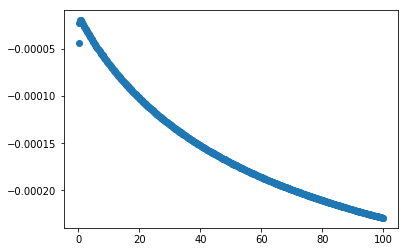

In [10]:
plt.plot(delta_seq, effects, 'o')
plt.show()

In [11]:
ipse.influence_function(df, treatment, cov, outcome, features, delta, model_y, model_t)

0       -1.056116e-07
1       -1.028660e-08
2       -5.429106e-10
3       -8.693556e-09
4       -1.299132e-08
             ...     
45206    1.941797e-06
45207    6.129557e-06
45208   -7.241363e-11
45209   -1.692851e-07
45210    4.137749e-37
Length: 45211, dtype: float64